# Calculating sulfur and trace element evaluation during mantle melting with changing SCSS and K$_D$s
- This notebook shows how to use the mantle melting model of Lee et al. (2012) adapted by Wieser et al. (2020) to model how S, Cu and other chalcophile or lithophile elements evolve during mantle melting
- For more information on how the math works, we direct you towards the supporting information of Wieser et al (2020) - https://doi.org/10.1016/j.gca.2020.05.018 - Where the equations are typed out in detail
- Here, we do the more complex example where

## Loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PySulfSat as ss

## Example 1 - Non fixed S content
- The examples in the other workbook assume that S is fixed throughout the melting interval
- However, we know the concentration of mantle melts changes with increasing F, so ideally, we'd calculate how much S those melts can hold
- We can do this using an output from a melting model (here, Thermocalc). 

In [2]:
# Load a generic dataframe
Thermocalc_df=pd.read_excel('Thermocalc_Melting_Path.xlsx')

In [3]:
# Load a dataframe for calculating SCSS for these melt comps
Thermo_df_ss=ss.import_data('Thermocalc_Melting_Path.xlsx', 
                    suffix='_Liq')

We have replaced all missing liquid oxides and strings with zeros. 


### Calculate instanteous melts
- This dataframe contains aggregated melt compositions, we need instantenous melts for calculating the SCSS

In [4]:
Inst_Liq=ss.calculate_inst_melts_Thermocalc(Thermocalc_df=Thermocalc_df)

### TiO$_2$ is very bad from Thermocalc, lets calculate it using our melting functions here


In [5]:
KDs_TiO2=pd.DataFrame(data={'element': 'TiO2',
        'ol': 0.07, 'opx': 0.07, 
        'cpx': 0.07, 'sp': 0.07, 
        'gt': 0.07, 'sulf': 0.07}, index=[0])

### Extract the modes from Thermocalc

In [6]:
Modes3=pd.DataFrame(data={'ol=0': Thermocalc_df['ol'],
                        'cpx': Thermocalc_df['cpx'],
                        'opx': Thermocalc_df['opx'],
                        'sp': Thermocalc_df['sp'],
                        'gt': Thermocalc_df['g']*0})

In [7]:
df_TiO2_Thermocalc=ss.Lee_Wieser_sulfide_melting(F=Thermocalc_df['liq'], 
                        Modes=Modes3,
                        KDs=KDs_TiO2,
                        S_Sulf=330000, elem_Per=0.13,
                        S_Mantle=[200],
                        S_Melt_SCSS_2=1000,
                         Prop_S6=0)
Inst_Liq['TiO2_Liq']=df_TiO2_Thermocalc['TiO2_Melt_Inst']

### Lets calculate the SCSS using ONeill (2021)
- Wieser et al. (2020) show that the calculated sulfide composition isn't very reliable at mantle PT, so we use a fixed mantle S composition of Fe/(Fe+Ni+Cu)=0.634

In [8]:
SCSS_fixedSulf=ss.calculate_O2021_SCSS(df=Inst_Liq,
T_K=Thermocalc_df['T']+273.15, P_kbar=Thermocalc_df['P'],
Fe_FeNiCu_Sulf=0.634)
SCSS_fixedSulf.head()

Using inputted Fe_FeNiCu_Sulf ratio for calculations.


,SCSS2_ppm,LnS,Ln_a_FeO,Ln_a_FeS,DeltaG,LnCS2_calc,SiO2_Liq,Al2O3_Liq,CaO_Liq,MgO_Liq,FeO_Liq,Na2O_Liq,Fe2O3_Liq,FeOt_Liq,TiO2_Liq,P2O5_Liq,Fe_FeNiCu_Sulf_calc
0,1044.741097,6.951524,-2.187206,-0.532776,6.105676,-0.808582,48.30,15.09,10.22,12.50,9.40,3.88,0.54,9.885892,0.000000,0,0.634
1,1148.958967,7.046612,-2.298092,-0.530853,6.098787,-0.819413,48.20,15.07,10.35,12.57,9.41,3.80,0.52,9.877896,3.579360,0,0.634
2,1143.600564,7.041937,-2.275975,-0.531455,6.091909,-0.794492,48.02,15.01,10.59,12.71,9.43,3.62,0.50,9.879900,2.624868,0,0.634
3,1145.446166,7.043550,-2.259674,-0.531816,6.085093,-0.769401,47.84,14.98,10.86,12.88,9.45,3.47,0.48,9.881904,1.916401,0,0.634
4,1151.313513,7.048659,-2.249086,-0.532229,6.078288,-0.746486,47.66,14.90,11.08,13.00,9.47,3.31,0.46,9.883908,1.392579,0,0.634


### Now we are ready to model S-Cu
- instead of inputting a single value for S_melt_SCSS_2, we input the pandas dataframe. 

In [10]:
KDs_Cu=pd.DataFrame(data={'element': 'Cu',
        'ol': 0.048, 'opx': 0.034, 
        'cpx': 0.043, 'sp': 0.223, 
        'gt': 0, 'sulf': 800}, index=[0])

Modes=pd.DataFrame(data={'ol': 0.6, 'opx': 0.2, 
       'cpx': 0.18, 'sp': 0.02, 'gt': 0}, index=[0])

# Lets run the simple model for comparison
S_Sulf = 38*(10**4)
df_Cu_200S=ss.Lee_Wieser_sulfide_melting(F=Thermocalc_df['liq'], 
                        Modes=Modes,
                        KDs=KDs_Cu,
                        S_Sulf=S_Sulf, elem_Per=30,
                        S_Mantle=[200],
                        S_Melt_SCSS_2=1000,
                         Prop_S6=0)
# Now lets change S

df_Cu_200S_Thermocalc=ss.Lee_Wieser_sulfide_melting(F=Thermocalc_df['liq'], 
                        Modes=Modes3,
                        KDs=KDs_Cu,
                        S_Sulf=S_Sulf, elem_Per=30,
                        S_Mantle=[200],
                        S_Melt_SCSS_2=SCSS_fixedSulf['SCSS2_ppm'],
                         Prop_S6=0)

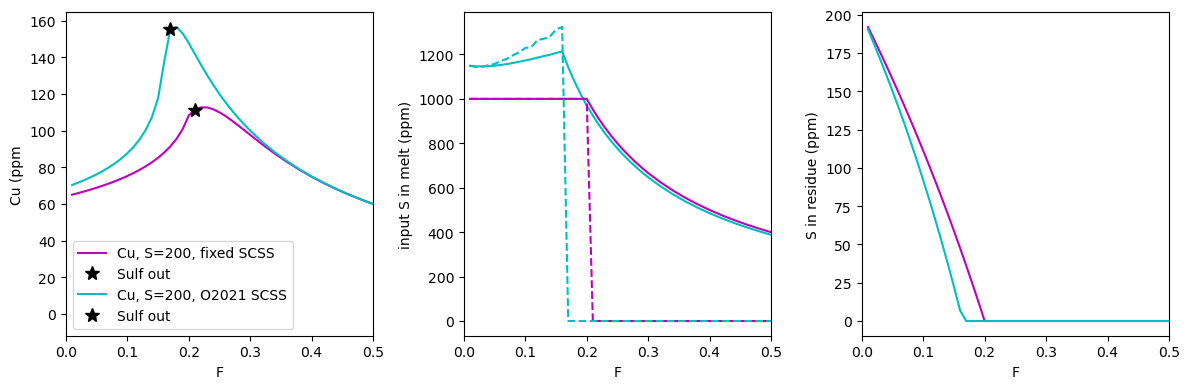

In [12]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12,4), sharex=True)
# 100 ppm
ax1.plot(df_Cu_200S['F'].iloc[1:], 
         df_Cu_200S['Cu_Melt_Agg'].iloc[1:],
        '-',color='m', ms=10, label='Cu, S=200, fixed SCSS')
# Lets add a cross to show the point at which sulfide is exhausted
sulf_out_200=np.take(np.where(df_Cu_200S['S_Residue']==0), 0)
ax1.plot(df_Cu_200S['F'].loc[sulf_out_200], 
         df_Cu_200S['Cu_Melt_Agg'].loc[sulf_out_200],
        '*k', ms=10, label='Sulf out')


ax1.plot(df_Cu_200S_Thermocalc['F'].iloc[1:], 
         df_Cu_200S_Thermocalc['Cu_Melt_Agg'].iloc[1:],
        '-',color='c', ms=10, label='Cu, S=200, O2021 SCSS')
# Lets add a cross to show the point at which sulfide is exhausted
sulf_out_200=np.take(np.where(df_Cu_200S_Thermocalc['S_Residue']==0), 0)
ax1.plot(df_Cu_200S_Thermocalc['F'].loc[sulf_out_200], 
         df_Cu_200S_Thermocalc['Cu_Melt_Agg'].loc[sulf_out_200],
        '*k', ms=10, label='Sulf out')
ax1.set_xlim([0, 0.5])
ax1.set_xlabel('F')
ax1.set_ylabel('Cu (ppm')

# Plot S in melt
ax2.plot(df_Cu_200S['F'].iloc[1:], 
         df_Cu_200S['S_Melt_Agg'].iloc[1:],
        '-',color='m', ms=10, label='Cu, S=200, fixed SCSS')

ax2.plot(df_Cu_200S_Thermocalc['F'].iloc[1:], 
         df_Cu_200S_Thermocalc['S_Melt_Agg'].iloc[1:],
        '-',color='c', ms=10, label='Cu, S=200, O2021 SCSS')

ax2.plot(df_Cu_200S['F'].iloc[1:], 
         df_Cu_200S['S_Melt_Inst'].iloc[1:],
        '--',color='m', ms=10, label='Cu, S=200, fixed SCSS')

ax2.plot(df_Cu_200S_Thermocalc['F'].iloc[1:], 
         df_Cu_200S_Thermocalc['S_Melt_Inst'].iloc[1:],
        '--',color='c', ms=10, label='Cu, S=200, O2021 SCSS')




ax2.set_xlabel('F')
ax2.set_ylabel('input S in melt (ppm)')

# S in source
ax3.plot(df_Cu_200S['F'].iloc[1:], 
         df_Cu_200S['S_Residue'].iloc[1:],
        '-',color='m', ms=10, label='Cu, S=200, fixed SCSS')

ax3.plot(df_Cu_200S_Thermocalc['F'].iloc[1:], 
         df_Cu_200S_Thermocalc['S_Residue'].iloc[1:],
        '-',color='c', ms=10, label='Cu, S=200, O2021 SCSS')

ax3.set_xlabel('F')
ax3.set_ylabel('S in residue (ppm)')
fig.tight_layout()
ax1.legend()

## Example 2 - Variable KD
- We can be even 'cleverer' than this. So far, we have assumed the KDs stay constant, but that isn't the case. We know from Kiseeva et al. (2015) that the KD of Cu in the sulfide depends on the FeOt content of the melt, the sulfide composition and the temperature. 
- Following Ding and Dasgupta, lets calculate KD using 5 wt% Cu and 20 wt% Ni in the mantle sulfide

### Calculate KD using Kiseeva, using a fixed sulfide composition. 

In [13]:
Sulf_KDs_Kis=ss.calculate_sulf_kds(Ni_Sulf=5, Cu_Sulf=20,
        FeOt_Liq=Thermocalc_df['FeOt'],  
        T_K=Thermocalc_df['T']+273.15, Fe3Fet_Liq=0)
Sulf_KDs_Kis.head()

,S_Sulf,O_Sulf,Fe_Sulf,Ni_Sulf,Cu_Sulf,DNi,DCu,DAg,DPb,DZn,...,DIn,DTi,DGa,DSb,DCo,DV,DGe,DCr,DSe_B2015,DTe_B2015
0,28.951975,2.040467,44.007558,5,20,468.888700,423.437545,387.173238,24.179410,2.000184,...,13.909661,0.009705,0.069138,31.618608,33.696187,0.213793,1.418172,1.365763,1194.743950,11164.888225
1,28.954668,2.038823,44.006509,5,20,467.544755,421.716344,385.632376,24.167264,2.003319,...,13.914218,0.009722,0.069545,31.714442,33.678820,0.214521,1.425514,1.369429,1195.816660,11175.374871
2,28.954331,2.039029,44.006641,5,20,465.786726,419.721374,383.854833,24.132319,2.004770,...,13.901989,0.009734,0.069894,31.771584,33.629184,0.215073,1.430966,1.371968,1195.682200,11174.060687
3,28.953993,2.039235,44.006772,5,20,464.050446,417.753198,382.100957,24.097713,2.006208,...,13.889863,0.009746,0.070241,31.828280,33.580030,0.215621,1.436388,1.374488,1195.547751,11172.746524
4,28.953656,2.039441,44.006904,5,20,462.323330,415.797345,380.357852,24.063208,2.007645,...,13.877764,0.009758,0.070590,31.884979,33.531021,0.216170,1.441821,1.377008,1195.413312,11171.432383


### Now lets make a dataframe of KDs
- You could also set the silicate KDs to vary based on any other Kd models you have for them in the same way as above/

In [14]:
KDs_Cu_Kis=pd.DataFrame(data={'element': 'Cu',
        'ol': 0.048, 'opx': 0.034, 
        'cpx': 0.043, 'sp': 0.223, 
        'gt': 0, 'sulf': Sulf_KDs_Kis['DCu']})

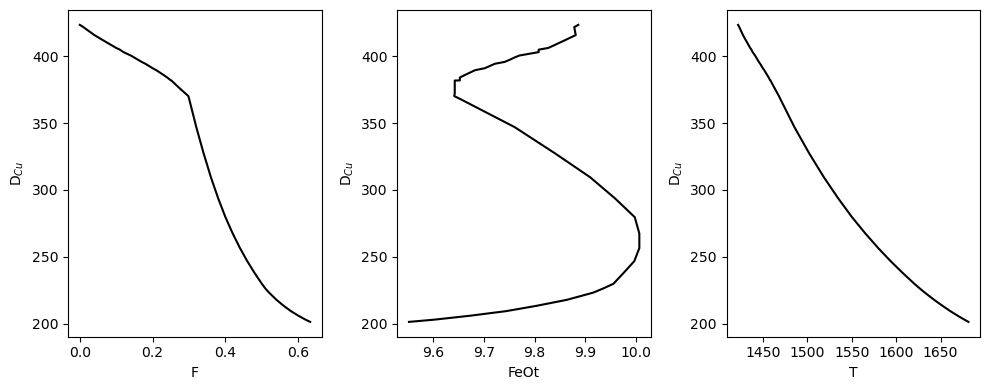

In [15]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(10,4))

ax1.plot(Thermocalc_df['liq'],
         Sulf_KDs_Kis['DCu'], '-k')
ax1.set_xlabel('F')
ax1.set_ylabel('D$_{Cu}$')

ax2.plot(Thermocalc_df['FeOt'],
         Sulf_KDs_Kis['DCu'], '-k')
ax2.set_xlabel('FeOt')
ax2.set_ylabel('D$_{Cu}$')

ax3.plot(Thermocalc_df['T'],
         Sulf_KDs_Kis['DCu'], '-k')
ax3.set_xlabel('T')
ax3.set_ylabel('D$_{Cu}$')
fig.tight_layout()

In [16]:
df_Cu_200S_Thermocalc_Kis=ss.Lee_Wieser_sulfide_melting(F=Thermocalc_df['liq'], 
                        Modes=Modes3,
                        KDs=KDs_Cu_Kis,
                        S_Sulf=S_Sulf, elem_Per=30,
                        S_Mantle=[200],
                        S_Melt_SCSS_2=SCSS_fixedSulf['SCSS2_ppm'],
                         Prop_S6=0)

# Lets also model Selenium
df_Cu_200S_Thermocalc_Kis=ss.Lee_Wieser_sulfide_melting(F=Thermocalc_df['liq'], 
                        Modes=Modes3,
                        KDs=KDs_Cu_Kis,
                        S_Sulf=S_Sulf, elem_Per=30,
                        S_Mantle=[200],
                        S_Melt_SCSS_2=SCSS_fixedSulf['SCSS2_ppm'],
                         Prop_S6=0)

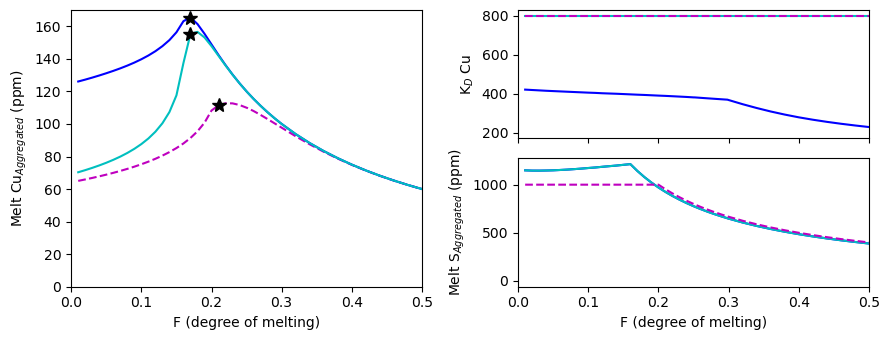

In [19]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
figure_mosaic="""
    AB
    AC

    """
fig,axes=plt.subplot_mosaic(mosaic=figure_mosaic, figsize=(9, 3.5), sharex=True)

axes['A'].plot(df_Cu_200S['F'].iloc[1:], 
         df_Cu_200S['Cu_Melt_Agg'].iloc[1:],
        '--',color='m', ms=10, label='Cu, S=200 ppm, simple')
# Lets add a cross to show the point at which sulfide is exhausted
sulf_out_200=np.take(np.where(df_Cu_200S['S_Residue']==0), 0)
axes['A'].plot(df_Cu_200S['F'].loc[sulf_out_200], 
         df_Cu_200S['Cu_Melt_Agg'].loc[sulf_out_200],
        '*k', ms=10, label='Sulf out')




# Kiseeva KDs, O2021 SCSS
axes['A'].plot(df_Cu_200S_Thermocalc_Kis['F'].iloc[1:], 
         df_Cu_200S_Thermocalc_Kis['Cu_Melt_Agg'].iloc[1:],
        '-',color='b', ms=10, label='Cu, S=200 ppm, Kiseeva KDs, O2021 SCSS')
# Lets add a cross to show the point at which sulfide is exhausted
sulf_out_200=np.take(np.where(df_Cu_200S_Thermocalc_Kis['S_Residue']==0), 0)
axes['A'].plot(df_Cu_200S_Thermocalc_Kis['F'].loc[sulf_out_200], 
         df_Cu_200S_Thermocalc_Kis['Cu_Melt_Agg'].loc[sulf_out_200],
        '*k', ms=10, label='Sulf out')

# FixedKD, O2021 SCSS

axes['A'].plot(df_Cu_200S_Thermocalc['F'].iloc[1:], 
         df_Cu_200S_Thermocalc['Cu_Melt_Agg'].iloc[1:],
        '-',color='c', ms=10, label='Cu, S=200, KD=800, O2021 SCSS')
# Lets add a cross to show the point at which sulfide is exhausted
sulf_out_200=np.take(np.where(df_Cu_200S_Thermocalc['S_Residue']==0), 0)
axes['A'].plot(df_Cu_200S_Thermocalc['F'].loc[sulf_out_200], 
         df_Cu_200S_Thermocalc['Cu_Melt_Agg'].loc[sulf_out_200],
        '*k', ms=10, label='Sulf out')
axes['A'].set_xlim([0, 0.5])
axes['A'].set_xlabel('F (degree of melting)')
axes['A'].set_ylabel('Melt Cu$_{Aggregated}$ (ppm)')
axes['A'].set_ylim([0, 170])


axes['B'].plot(df_Cu_200S_Thermocalc_Kis['F'].iloc[1:],
               KDs_Cu_Kis['sulf'].iloc[1:], '-b')
axes['B'].plot(df_Cu_200S_Thermocalc['F'].iloc[1:],
               df_Cu_200S_Thermocalc['F'].iloc[1:]*0+800, '-c')
axes['B'].plot(df_Cu_200S['F'].iloc[1:],
               df_Cu_200S['F'].iloc[1:]*0+800, '--m')
axes['B'].set_ylabel('K$_D$ Cu')

axes['C'].plot(df_Cu_200S_Thermocalc_Kis['F'].iloc[1:],
               df_Cu_200S_Thermocalc_Kis['S_Melt_Agg'].iloc[1:], '-b')
axes['C'].plot(df_Cu_200S_Thermocalc['F'].iloc[1:],
               df_Cu_200S_Thermocalc['S_Melt_Agg'].iloc[1:], '-c')
axes['C'].plot(df_Cu_200S['F'].iloc[1:],
               df_Cu_200S['S_Melt_Agg'].iloc[1:], '--m')



axes['C'].set_xlabel('F (degree of melting)')
axes['C'].set_ylabel('Melt S$_{Aggregated}$ (ppm)')
fig.tight_layout()
fig.savefig('Complex_Models.png', dpi=300)

In [18]:
df_Cu_200S['S_Melt_Agg']

0        0.000000
1     1000.000000
2     1000.000000
3     1000.000000
4     1000.000000
5     1000.000000
6     1000.000000
7     1000.000000
8     1000.000000
9     1000.000000
10    1000.000000
11    1000.000000
12    1000.000000
13    1000.000000
14    1000.000000
15    1000.000000
16    1000.000000
17    1000.000000
18    1000.000000
19    1000.000000
20    1000.000000
21     952.380952
22     909.090909
23     869.565217
24     833.333333
25     800.000000
26     794.596742
27     769.230769
28     740.740741
29     714.285714
30     689.655172
31     670.465974
32     666.666667
33     625.000000
34     588.235294
35     555.555556
36     526.315789
37     500.000000
38     476.190476
39     454.545455
40     434.782609
41     416.666667
42     400.000000
43     392.464678
44     384.615385
45     370.370370
46     357.142857
47     344.827586
48     333.333333
49     322.580645
50       0.000000
Name: S_Melt_Agg, dtype: float64